# <center> </center>
# <center> 4b. SETAR Application
## <center> ECO374

If using Colab, mount Google Drive and set path to files

In [1]:
import os
IN_COLAB = 'COLAB_GPU' in os.environ  
if IN_COLAB:
  from google.colab import drive; mount_path = '/content/drive'
  not os.path.ismount(mount_path) and drive.mount(mount_path)
  os.chdir('/content/drive/MyDrive/Colab Notebooks/Python_code') # Set Python file directory 

Set up R for Python

In [2]:
import R_for_Python_setup as RPY
RPY.setup_R()
ro, pandas2ri, StrVector = RPY.initialize_rpy2()
%load_ext rpy2.ipython

R installed
Operating system: Windows
Development tool: Anaconda


Load R packages

In [3]:
R_packages = ['forecast', 'tsDyn']
RPY.load_R_packages(R_packages)

R packages loaded: forecast, tsDyn


Load Python packages

In [4]:
pth_packages = ['pandas_datareader']
import subprocess, sys
for pkg in pth_packages: subprocess.run([sys.executable, '-m', 'pip', 'install', pkg, '--quiet'], check=True)
import numpy as np, pandas as pd, pandas_datareader.data as web, datetime as dt
import matplotlib.pyplot as plt, matplotlib.dates as mdates

# 1. Data
3-month U.S. treasury bills ([Source](https://fred.stlouisfed.org/series/TB3MS))

In [5]:
TB3MS = web.DataReader('TB3MS', 'fred', start=dt.datetime(1934,1,1), end=dt.datetime(2025,3,1))

Plot the data

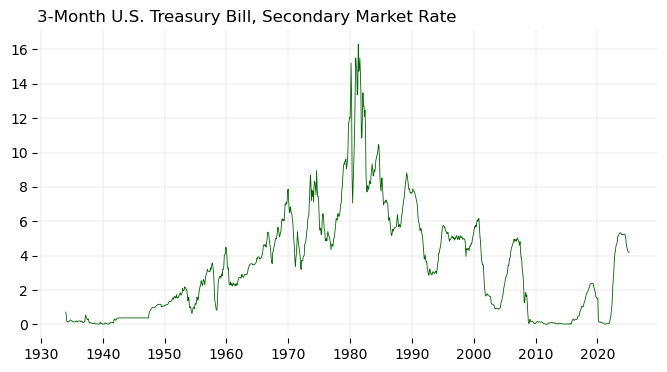

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(TB3MS, '-', color='darkgreen', linewidth=0.6)
plt.title('3-Month U.S. Treasury Bill, Secondary Market Rate', loc='left')
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.show()

# 2. SETAR Model
Estimate a SETAR model with a 6% threshold

In [7]:
ro.globalenv['TB3MS'] = TB3MS['TB3MS'] # copy data from Python to R

In [8]:
%%R
threshold <- 6
SETAR <- tsDyn::setar(TB3MS, mL=1, mH=1, th=threshold)
print(SETAR)


Non linear autoregressive model

 2 regimes) (
Coefficients:
Low regime:
   const.L     phiL.1 
0.01106875 0.99805697 

High regime:
  const.H    phiH.1 
0.3681101 0.9552528 

Threshold:
Z(t) = + (1) X(t)
-Value: 6 (fixed)
Proportion of points in low regime: 82.54% 	 High regime: 17.46% 


# 3. Forecast

In [9]:
%%R
h_steps <- 12 # set the forecast time horizon
TB3MS_forecast <- stats::predict(SETAR, n.ahead=h_steps) # generate forecast

In [10]:
TB3MS_forecast = ro.globalenv['TB3MS_forecast'] # copy data from R to Python
h_steps = int(ro.globalenv['h_steps'][0])

In [11]:
id = TB3MS.index
id_f = pd.date_range(start=id[-1]+pd.DateOffset(1), periods=h_steps, freq='MS')
TB3MS_f = pd.DataFrame(index=id_f, data={'forecast': TB3MS_forecast})

# 4. Plot
Plot part of the original series and the forecast

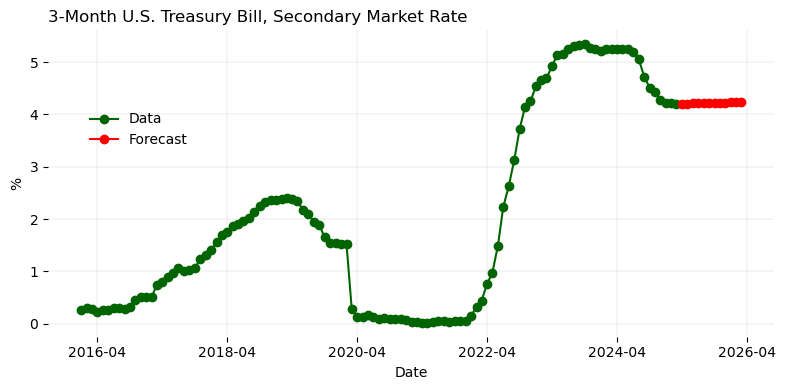

In [12]:
start_plot = pd.to_datetime('2016-01-01')
TB3MS_s = TB3MS[TB3MS.index >= start_plot]

plt.figure(figsize=(8, 4))
plt.plot(TB3MS_s.index, TB3MS_s['TB3MS'], label='Data', color='darkgreen', linestyle='-', marker='o')
plt.plot(TB3MS_f.index, TB3MS_f['forecast'], label='Forecast', color='red', linestyle='-', marker='o')

plt.xlabel('Date')
plt.ylabel('%')
plt.title('3-Month U.S. Treasury Bill, Secondary Market Rate', loc='left')
plt.legend(loc=(0.05, 0.6), frameon=False)
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=24))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()

Plot subset of data and 1-step ahead in-sample forecasts

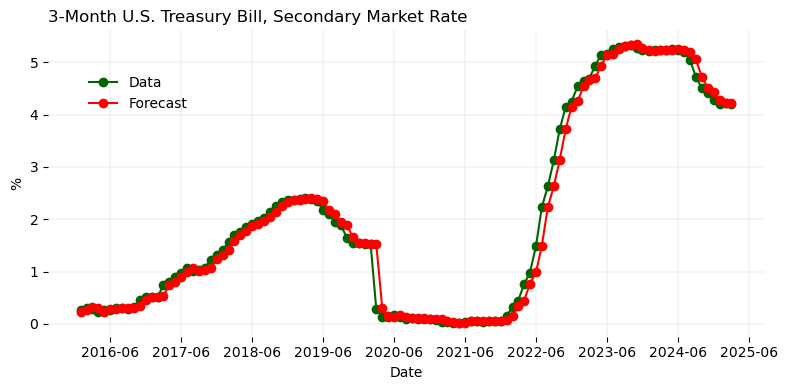

In [13]:
data = TB3MS
f_start = pd.to_datetime('2016-01-01')
T = len(data)
y = data[data.index >= f_start].copy()
s = len(y)
y['y_hat'] = 0.

for j in range(s):
    t = T-s+j
    ydat = data.iloc[:t]
    ro.globalenv['ydat'] = ydat['TB3MS'] 
    ro.r('ST <- tsDyn::setar(ydat, mL=1, mH=1, th=threshold)')
    ro.r('yh <- stats::predict(ST, n.ahead=1)')   
    yh = ro.globalenv['yh'] 
    y.at[y.index[j], 'y_hat'] = yh

plt.figure(figsize=(8, 4))
# plot data
plt.plot(y.index, y['TB3MS'], label='Data', color='darkgreen', linestyle='-', marker='o')
# plot forecast
plt.plot(y.index, y['y_hat'], label='Forecast', color='red', linestyle='-', marker='o')

plt.xlabel('Date')
plt.ylabel('%')
plt.title('3-Month U.S. Treasury Bill, Secondary Market Rate', loc='left')
plt.legend(loc=(0.05, 0.72), frameon=False)
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12)) # labels every 12 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()

Plot subset of data and 1-step ahead in-sample forecasts